# Load packages and create definitions needed

In [1]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt


## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der
from sklearn.preprocessing import StandardScaler

# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
from tools.loading import load_data_single_mod


## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed

/home/snath/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: package or namespace load failed for ‘RevoUtilsMath’:
 .onLoad failed in loadNamespace() for 'RevoUtilsMath', details:
  call: NULL
  error: Remove Microsoft R and then re-install.
Be sure to select MKL libraries as an install option.

  warnings.warn(x, RRuntimeWarning)
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


# Definitions

In [2]:
#Calculate quantile values for each emulated value at each timestep in relation to the emulated ensemble distribution
#At that timestep
from scipy.stats import percentileofscore

def get_percentiles(x,y):
    
    '''
    input variables
    ---------------
    
    x = monthly tempertaure value for all emulations/initial condition ensemble members (dimension 1)
        dimension 2 is the time step
    y = monthly tempertaure values for a single emulation/initial condition ensemble member
    
    output variables
    ----------------
    
    list of precentile value an ensemble member/emulated monthly temperature has
    in relation to the whole emulated/modelled distribution at the given time step
    
    '''
    
    return [percentileofscore(x[:,i_t%x.shape[1]],
            y[i_t],kind='mean') for i_t in range(y.shape[0])]
    
    
     

In [3]:
## Use this for if you don't want to experiment with loss functions

from scipy.optimize import curve_fit

def psuedo_inverse_quantile_reg(x, alpha, y):
      
    
    '''
    input variables
    ---------------
    
    x = monthly/yearly regional/grid point emulated temperature anomaly
    alpha = the position of x (i.e. quantile) within the whole emulated 
            ensemble for its respective year timestep 
    y = the GMT at the yearly timestep
    
    
    output variables
    ----------------
    a, b, c = coefficient a and c reverse the pattern scaling, coefficient b is the statistically derived 𝜎
    
    ----------------------------------------------------------
    Fits the function to reverse the impact chain, following:
    
    alpha = Φ[(x−𝜇)/𝜎] (1)
    
    where Φ is a standard normal cdf, and hence:
    
    𝜇 = x − 𝜎*Φ^{-1}(alpha) (2)
    
    and hence to get GMT we first scale back to the mean response using (2) before reversing the pattern
    scaling
    
    y = a*(x − 𝜎*Φ^{-1}(alpha) - c)
    
    Notes:
    ------
    
    From Beusch et al. (2021)
    
    𝜇  ≈ d*GMT^smooth + e
    
    hence a ~ 1/d and c ~ e, have the initial guesses of:
     - 0.5 for a (since we assume land warms up faster than GMT) 
     - the mean temperature value (without outliers) over the given region/grid point for b 
       (since we add a mean offset after scaling with GMT anomaly)
    
    '''
    
    def func(X, a, b, c):
        
        '''
        Define the function to reverse pattern scaling
        
        X = (x,alpha)
        
        '''
        
        x,alpha = X
        alpha = norm.ppf(alpha)
        
        return a*(x - b*alpha - c)
    
    ## Define initial guesses
    ## a is initialised 0.5 as GMT to grid point level slope relationship
    ## b is 𝜎 over values
    ## c is the trim mean over x (so as to not consider outliers)
    
    p0 = np.array([0.5,np.nanstd(x),trim_mean(x,0.02)])
    
    return curve_fit(func, (x,alpha), y, p0)[0]



In [4]:
## Use this if you want to experiment with loss functions 
## Used log cosh loss: https://openreview.net/forum?id=rkglvsC9Ym

from scipy.stats import norm, trim_mean

def psuedo_inverse_quantile_reg(x,y,alpha):
    
    '''
    input variables
    ---------------
    
    x = monthly/yearly regional/grid point emulated temperature anomaly
    alpha = the position of x (i.e. quantile) within the whole emulated 
            ensemble for its respective year timestep 
    y = the GMT at the yearly timestep
    
    function
    ---------
    
    Following:
    
    alpha = Φ[(x−𝜇)/𝜎] (1)
    
    where Φ is a standard normal cdf, and hence:
    
    𝜇 = x − 𝜎*Φ^{-1}(alpha) (2)
    
    and hence to get GMT we first scale back to the mean response using (2) before reversing the pattern
    scaling
    
    y = a*(𝜇 - b)
    
    output variables
    ----------------
    
    coefficients a, 𝜎 and b
    
    '''

    def _psuedo_inverse_loss(coeff):
        """Return the RMSE of predictions i.e. OLSR"""
        
        y_preds=coeff[0]*(x - coeff[1]*norm.ppf(alpha) - coeff[2])
        
        loss=0
        for y_pred,i_y in zip(y_preds,y):
            
            loss+=np.log(np.cosh(y_pred-i_y))/len(y_preds)

        
        return loss
        
    x = x[~np.isnan(x)]
    
    
    return minimize(_psuedo_inverse_loss, np.array([0.5,np.nanstd(x),trim_mean(x,0.02)])).x

        
    

# Load models

In [ ]:
##Start training for monthly downscaling
Tmonglob_wgt={}
y={}
y_mon={}
time_mon={}

y_all_mon={}
Tmonglob_all={}


for model in ['MIROC6']:
        
        print("calculating seasonal trends for" ,model)
        
        ##Get training values i.e. monthly/daily model run datas for selected models
        y_mon[model],time_mon[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l,Tmonglob_wgt[model]=load_data_single_mod(6,model,'ssp585',Tanglob_idx=True,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01',usr_time_res="mon")
        
        #Get model metrics
        nr_ts = int(len(time_mon[model])/12) #nr time steps (CAMS-CSM1-0 is 230, all others 231)
        nr_runs = len(y_mon[model].keys())
        
        ##get training data

        # prepare the inputs as array
        Tmonglob_all[model] = np.zeros([12*nr_ts*nr_runs]) 
        y_all_mon[model] = np.zeros([12*nr_ts*nr_runs,idx_l.sum()]) 

        i_mon=0
        for run in range(1,nr_runs+1):
            
            ##store all ensemble members/emulations in a single array making it easier for future training
            
            Tmonglob_all[model][i_mon:i_mon+(nr_ts*12)]=np.average(y_mon[model][run][:12*nr_ts],weights=wgt_l,axis=1)
            y_all_mon[model][i_mon:i_mon+(nr_ts*12)]=y_mon[model][run][:12*nr_ts]
            i_mon+=(nr_ts*12)
            


# Data preprocessing

In [6]:
## first generate land-sea mask

import mplotutils as mpu

frac_l = xr.open_mfdataset('/net/so4/landclim/snath/data/interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

#land-sea mask of ERA-interim bilinearily interpolated 
frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
frac_l = frac_l.where(frac_l.lat>-60,0) # remove Antarctica from frac_l field (ie set frac l to 0)
idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idex land #-> everything >0 I consider land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)

srex_raw = xr.open_mfdataset('/net/so4/landclim/snath/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)
srex_vals=srex_raw.srex_mask.values
lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values)

## get lat lon coords of land grid points
lat_grid = np.array(lats[idx_l])
lon_grid = np.array(lons[idx_l])

srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU']



## Get monthly quantiles

In [ ]:
model = 'MIROC6'

quantiles={}

for i_mon in range(12):
    
    ##parallelised across all grid points, otherwise quite slow
    
    quantiles[i_mon]=Parallel(n_jobs=10)(delayed(get_percentiles)(y_all_mon[model][:,:,i_mon,i_grid],
                                                       y_all_mon[model].reshape(-1,12,idx_l.sum())[:,i_mon,i_grid]) for i_grid in tqdm(np.arange(idx_l.sum())))

    
## don't want quantiles in a list, store it in an array therefore (probable more efficient ways to do this)
quantiles_temp=np.zeros_like(y_all_mon[model].reshape(-1,12,idx_l.sum()))

for i_mon in range(12):
    
    for i_grid in np.arange(idx_l.sum()):
        
        quantiles_temp[:,i_mon,i_grid]=quantiles[i_mon][i_grid]
        
quantiles=quantiles_temp/100


## Get yearly quantiles 

In [7]:
model = 'MIROC6'

quantiles_year=Parallel(n_jobs=10)(delayed(get_percentiles)(np.average(y_all_mon[model].reshape(nr_runs,-1,12,idx_l.sum())[:,:,:,i_grid],axis=2),
                                                       np.average(y_all_mon[model].reshape(-1,12,idx_l.sum())[:,:,i_grid],axis=1)) for i_grid in tqdm(np.arange(idx_l.sum())))

quantiles_temp=np.zeros([y_all_mon[model].reshape(-1,12,idx_l.sum()).shape[0],idx_l.sum()])

for i_grid in np.arange(idx_l.sum()):
    
    quantiles_temp[:,i_grid]=quantiles_year[i_grid]
    

quantiles_year=quantiles_temp/100
    

# Perform fit for impact chain reversal

In [26]:
from statsmodels.nonparametric.smoothers_lowess import lowess # lowess filter

i_mon = 6 ## if you want to do on a monthly level

inverse_quantile_coeff = {}
Tanglob_pred = {}
variable_parameters = {}

for model in ['MIROC6']:
    
    nr_ts=231
    y_all = np.nanmean(y_all_mon[model].reshape(nr_runs,-1,12,idx_l.sum()),axis=2) ## get yearly mean
    
    Tglob=np.tile(lowess(np.average(Tmonglob_all[model].reshape(-1,nr_ts,12),axis=(0,2)),np.arange(nr_ts),return_sorted=False,frac=50/nr_ts,it=0),
                  len(y_mon[model])) ## get GMT trend term as according to Beusch et al. (2021)
    
    inverse_quantile_coeff[model] = {}
    Tanglob_pred[model] = {}
    variable_parameters[model] = {}
    
    ## Do fitting for region of interest
    for reg in ['CEU','WNA','SAS']:
        
        print('Calculating model for: ', reg)
        
        idx_reg = srex_names.index(reg)+1 # index region
        idx_reg_l = (srex_raw.srex_mask.values[idx_l]==idx_reg)
        idx_reg_l_grid = (srex_raw.srex_mask.values==idx_reg) & idx_l
        
        ## store grid points within region for individual fitting so as to measure uncertainty in parameters
        grid_points=np.arange(3043)[idx_reg_l]
        
        ## get the percentile values for each emulation/ensemble member at each timestep over the region
        percentile_reg=np.array((get_percentiles(np.average(y_all[:,:,idx_reg_l],axis=2,weights=wgt_l[idx_reg_l]),
                                                       np.average(y_all.reshape(-1,idx_l.sum())[:,idx_reg_l],axis=1,weights=wgt_l[idx_reg_l]))))/100
        
        
        ## perform regression
        inverse_quantile_coeff[model][reg]=psuedo_inverse_quantile_reg(np.average(y_all.reshape(-1,idx_l.sum())[:,idx_reg_l],axis=1,weights=wgt_l[idx_reg_l]),
                                                                              Tglob,percentile_reg)
        
        ## store predicted values
        Tanglob_pred[model][reg]=inverse_quantile_coeff[model][reg][0]*(np.average(y_all.reshape(-1,idx_l.sum())[:,idx_reg_l],axis=1,weights=wgt_l[idx_reg_l])\
                                    -inverse_quantile_coeff[model][reg][1]*norm.ppf(percentile_reg)-inverse_quantile_coeff[model][reg][2])
        
        ##repeat but for each grid point within the region
        print('Starting on individual grid points...')
        
        variable_parameters[model][reg] = np.zeros([3,len(grid_points)])
        idx_grid=0
        for i_grid in tqdm(grid_points):
            
            inverse_quantile_coeff_gp =psuedo_inverse_quantile_reg(y_all.reshape(-1,idx_l.sum())[:,i_grid],
                                                                              Tglob,quantiles_year[:,i_grid])
            
            ## Store the difference between the grid point coefficient obtained and that obtained over the whole region
            variable_parameters[model][reg][0,idx_grid] = inverse_quantile_coeff_gp[0] - inverse_quantile_coeff[model][reg][0]
            variable_parameters[model][reg][1,idx_grid] = inverse_quantile_coeff_gp[1] - inverse_quantile_coeff[model][reg][1]
            variable_parameters[model][reg][2,idx_grid] = inverse_quantile_coeff_gp[2] - inverse_quantile_coeff[model][reg][2]

            idx_grid+=1
            


Calculating model for:  CEU
Starting on individual grid points...



Calculating model for:  WNA
Starting on individual grid points...



Calculating model for:  SAS
Starting on individual grid points...


# Preliminary results

In [44]:
## get percentile values again
model = 'MIROC6'

Tglob_pred = {}

for reg in ['CEU','WNA','SAS']:
    
    print('Working on a 1/100 exceeded event for, ', reg)
    
    ##find temperature which has exceedance probability ~ 0.01 at 2015 (year index 145)
    reg_temp_values=np.average(y_all[:,:,idx_reg_l],axis=2,weights=wgt_l[idx_reg_l])
    temp_val=np.quantile(reg_temp_values[:,145],0.99)

    ## Create array over all possible exceedance probabilites
    percentile_of_val=np.arange(0.01,0.99,0.001)

    ## Initialise array to store GMT predictions in (1000 realisations created)
    Tglob_pred[reg]=np.zeros([500,len(percentile_of_val)])

    i_perc=0

    ## loop over all possible exceedance probabilties for the chosen event and calculate 1000 realisations of GMT
    for perc in percentile_of_val:

        Tglob_pred[reg][:,i_perc]=(inverse_quantile_coeff[model][reg][0]+np.random.normal(0,np.nanstd(variable_parameters[model][reg][0,:]),500))*\
            (temp_val\
            -(inverse_quantile_coeff[model][reg][1]+np.random.normal(0,np.nanstd(variable_parameters[model][reg][1,:]),500))*norm.ppf(perc)\
             - inverse_quantile_coeff[model][reg][2]+np.random.normal(0,np.nanstd(variable_parameters[model][reg][2,:]),500))

        i_perc+=1




Working on a 1/100 exceeded event for,  CEU
Working on a 1/100 exceeded event for,  WNA
Working on a 1/100 exceeded event for,  SAS


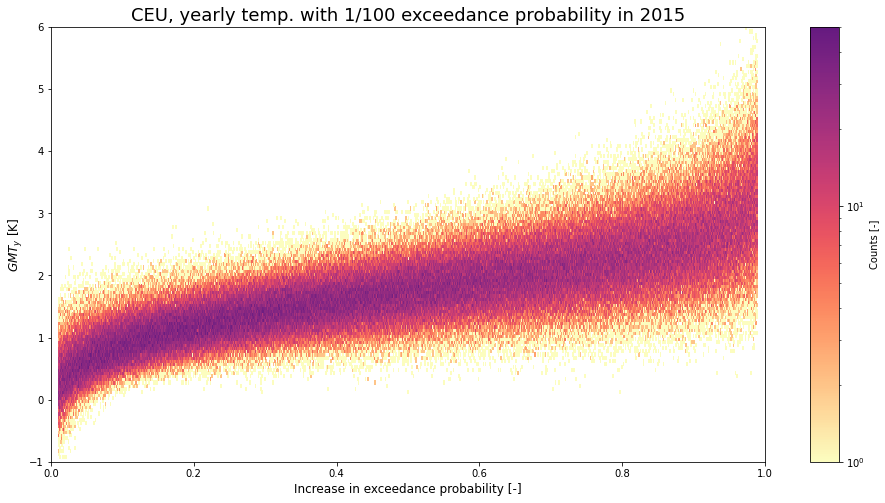

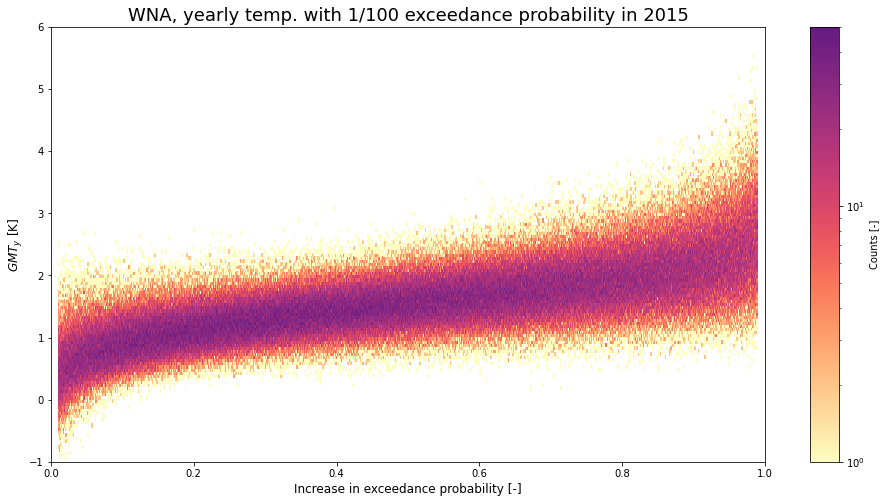

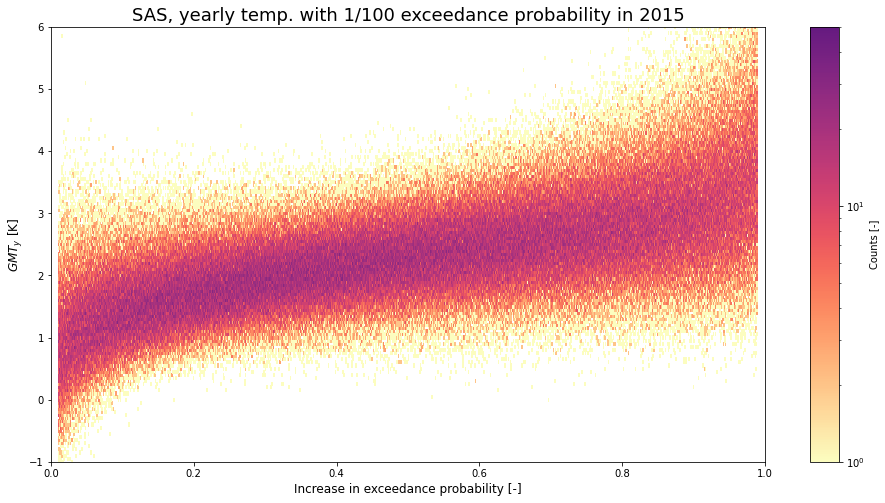

In [46]:
## Plots of results

from matplotlib.colors import LogNorm, LinearSegmentedColormap

for reg in ['CEU','WNA','SAS']:
    plt.figure(figsize=(16,8))

    my_map = LinearSegmentedColormap.from_list('my_colormap', plt.cm.magma_r(np.linspace(0, 1, 100))[:-30])

    extent_x=np.arange(0.01,0.99,0.001)
    extent_y=np.arange(Tglob_pred[reg].min(),Tglob_pred[reg].max(),0.05)

    plt.hist2d(1-np.tile(percentile_of_val,500),Tglob_pred[reg].flatten(),bins=[extent_x,extent_y],norm=LogNorm(),vmin=1,vmax=50,cmap=my_map,rasterized=True)
    plt.colorbar(aspect=15, label='Counts [-]')
    
    plt.ylim(-1,6)
    plt.xlim(0,1)

    plt.xlabel('Increase in exceedance probability [-]',fontsize=12)
    plt.ylabel(r'$GMT_{y}$ [K]',fontsize=12)
    plt.title(reg+', yearly temp. with 1/100 exceedance probability in 2015',fontsize=18)
    
